# UC B - Differential variant analysis to unveil cancer genes

Documentation: 
- http://gmql.eu/popstudy/api/ui/#/default/server.api.variants_in_region
- http://gmql.eu/popstudy/api/ui/#/default/server.api.donor_grouping

Requirements to run this demo: https://github.com/DEIB-GECO/VarSum/blob/master/demo/README_requirements

Try this demo online: https://colab.research.google.com/drive/1De9nU2b-IUBAbEe11L3Y7FmeogF7V4lz?usp=sharing

For this demo we took inspiration from the DiffMut technique developed at Singh-Lab (credits at the end) for differential analysis between somatic mutations and germline variation profiles. Considering a set of genes supposedly involved in a specific tumoral form, in our example the skin cutaneous melanoma, we are going to ask for each of them the variants located into the corresponding genomic area for healthy and non-healthy patients.

### Candidate genes

In [1]:
genes = ['CTSZ', 'EFEMP2', 'ITGA5', 'KDELR2', 'MDK', 'MICALL2', 'MAP2K3', 'PLAUR', 'SERPINE1', 'SOCS3']

Some utility functions

In [2]:
import requests
import json
import pandas as pd
import csv
from tqdm import tqdm
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

# make a request and check result
def post_request(to: str, argument, print_status_code=True, print_warnings=True, timeout=None):
    resp = requests.post(to, json=argument, timeout=timeout)
    if print_status_code:
        print(' response status code: {}'.format(resp.status_code))
    res_body = resp.json()
    if resp.status_code != 200:
        print(res_body)
    if print_warnings:
        print('warnings ?: {}'.format(res_body.get('notice')))
    return res_body



# call /variants_in_region and create a list of GENE_NAME + VARIANT
def get_variants_in_gene(genes, disease:str, in_cell_type:str) -> list:
    req_body = {
        'name': '!!!    WRITE HERE YOUR GENE NAME       !!!',  # gene name
        'of': {
            'assembly': 'GRCh38',
            'disease': disease,
            'having_variants': {
                'in_cell_type': [in_cell_type]
            }
        }
    }
    # make list of genes with their variants
    container = list()
    for gene in tqdm(genes):
        req_body['name'] = gene     # set gene
        res = post_request('http://gmql.eu/popstudy/api/variants_in_region', req_body, print_status_code=False, print_warnings=False)
        for variant in res['rows']:
            container.append([gene] + variant)  # gene, chrom, start, ref, alt
    return container




# call /variant_grouping and create a list with the number of donors for each of the input gene+variants
def get_variant_occurrence(gene_variants, disease:str, in_cell_type:str, to_csv:bool, filename:str):
    req_body = {
        "having_meta": {
            'assembly': 'GRCh38',
            'disease': disease
        },
        'having_variants': {
            'in_cell_type': [in_cell_type]
        },
        "target_variant": {'!!!       WRITE HERE YOUR VARIANT     !!!'},
        "group_by": ["health_status"]
    }
    # make list of variants with number of donors
    var_occurrence = list()
    for var in tqdm(gene_variants):
        req_body['target_variant'] = {'chrom': var[1], 'start': var[2], 'ref': var[3], 'alt': var[4]}
        res = post_request('http://gmql.eu/popstudy/api/variant_grouping', req_body, print_status_code=False, print_warnings=False)
        this_variant_occurrence = res['rows'][0][3]
        var_occurrence.append(var + [this_variant_occurrence])
    if to_csv:
        with open(filename, mode='w') as csv_file:
            writer = csv.writer(csv_file)
            writer.writerow(['GENE', 'CHROM', 'START', 'REF', 'ALT', 'DONORS'])
            for row in var_occurrence:
                writer.writerow(row)
            csv_file.truncate()
    return var_occurrence

def get_population_size(disease:str, in_cell_type:str) -> int:
    req_body = {
        "having_meta": {
            'assembly': 'GRCh38',
            'disease': disease
        },
        'having_variants': {
            'in_cell_type': [in_cell_type]
        },
        "group_by": ["health_status"]
    }
    res = post_request('http://gmql.eu/popstudy/api/donor_grouping', req_body, print_status_code=False, print_warnings=False)
    return res['rows'][0][1]

## To determine which of the candidate gene are most likely associated with the development of skin cutaneous melanoma, we proceed with the following steps:
1. Assign to each gene G a pair of scores. That is, for a cohort, the score is computed as the sum of the occurrences of every variant in gene G in the donors of the cohort. This number is then divided by the number of donors in the cohort.
2. Rank normalize the scores. The new scores represent with a number between 0 and 1 the likelihood of mutations and variants falling within the candidate genes relatively to the cohort.
3. Compare the rank normalized scores to find the genes where the mutation and variation profiles differ the most between the tumor cohort and the healthy cohort.

In the following, we perform the first two steps separately for the tumor cohort and for the healthy cohort. We identify these steps with a number for the step number and with a letter -- T for the tumor cohort,  H for the healthy cohort.


### 1.T

    (the argument to_csv=True saves the result of such function calls into a CSV that we can read later)

In [ ]:
# # read from CSV in the next code block - OR - uncomment the following lines
# mutations_tumor_cohort = get_variants_in_gene(
#     genes,
#     disease='skin cutaneous melanoma',
#     in_cell_type='somatic')
#
# occurrence_mutations_tumor_cohort = get_variant_occurrence(
#     mutations_tumor_cohort,
#     disease='skin cutaneous melanoma',
#     in_cell_type='somatic',
#     to_csv=True,
#     filename='occurrence_mutations_tumor_cohort_UC_B.csv')
# occurrence_mutations_tumor_cohort_df = pd.DataFrame.from_records(occurrence_mutations_tumor_cohort, columns=['GENE', 'CHROM', 'START', 'REF', 'ALT', 'DONORS'])
# occurrence_mutations_tumor_cohort_df

In [ ]:
occurrence_mutations_tumor_cohort_df = pd.read_csv('occurrence_mutations_tumor_cohort_UC_B.csv')
occurrence_mutations_tumor_cohort_df

In [6]:
df2 = occurrence_mutations_tumor_cohort_df \
.groupby(['GENE'])['DONORS'].sum().reset_index(name='SCORE(NOT_NORM)') \
.sort_values('SCORE(NOT_NORM)', ascending=False) \
.reset_index(drop=True)
# divide the SCORE by the population size
df2['SCORE(NOT_NORM)'] = df2['SCORE(NOT_NORM)'].div(get_population_size(disease='skin cutaneous melanoma', in_cell_type='somatic'))
df2

,GENE,SCORE(NOT_NORM)
0,ITGA5,0.098291
1,MICALL2,0.053419
2,SERPINE1,0.023504
3,PLAUR,0.019231
4,EFEMP2,0.017094
5,MAP2K3,0.014957
6,SOCS3,0.010684
7,KDELR2,0.008547
8,CTSZ,0.004274
9,MDK,0.002137


### 2.T Rank normalize the gene score in tumor cohort

In [7]:
max_mut = df2['SCORE(NOT_NORM)'][0]
df2['VARIANT_SCORE'] = df2.apply(lambda r: r['SCORE(NOT_NORM)']/max_mut, axis=1)

##  PLOT
#pd.pivot_table(df2.drop(['SCORE'], axis=1), index='GENE').plot(
#    kind='bar',
#    figsize=(6, 4),
#    legend=False
#)
#plt.title('Normalized score of somatic mutations in patients with skin cutaneous melanoma')
#plt.ylabel('RANK NORMALIZED SCORE ')
#plt.show()

df2

,GENE,SCORE(NOT_NORM),VARIANT_SCORE
0,ITGA5,0.098291,1.000000
1,MICALL2,0.053419,0.543478
2,SERPINE1,0.023504,0.239130
3,PLAUR,0.019231,0.195652
4,EFEMP2,0.017094,0.173913
5,MAP2K3,0.014957,0.152174
6,SOCS3,0.010684,0.108696
7,KDELR2,0.008547,0.086957
8,CTSZ,0.004274,0.043478
9,MDK,0.002137,0.021739


### 1.H Gene scores in healthy cohort

In [9]:
# # read from CSV in the next code block - OR - uncomment the following lines
# variants_healthy_cohort = get_variants_in_gene(genes, disease='none', in_cell_type='germline')
#
# occurrence_variants_healthy_cohort = get_variant_occurrence(
#     variants_healthy_cohort,
#     disease='none',
#     in_cell_type='germline',
#     to_csv=True,
#     filename='occurrence_variants_healthy_cohort_UC_B.csv')
# occurrence_variants_healthy_cohort_df = pd.DataFrame.from_records(occurrence_variants_healthy_cohort, columns=['GENE', 'CHROM', 'START', 'REF', 'ALT', 'DONORS'])
# occurrence_variants_healthy_cohort_df

In [10]:
occurrence_variants_healthy_cohort_df = pd.read_csv('occurrence_variants_healthy_cohort_UC_B.csv')
occurrence_variants_healthy_cohort_df

,GENE,CHROM,START,REF,ALT,DONORS
0,CTSZ,20,58995188,G,A,7
1,CTSZ,20,58995206,T,C,3
2,CTSZ,20,58995237,A,T,1
3,CTSZ,20,58995263,G,C,1
4,CTSZ,20,58995266,T,G,3
...,...,...,...,...,...,...
6130,SOCS3,17,78359985,C,A,47
6131,SOCS3,17,78360014,T,G,4490
6132,SOCS3,17,78360016,G,T,28
6133,SOCS3,17,78360017,C,T,28


In [11]:
df3 = occurrence_variants_healthy_cohort_df \
.groupby(['GENE'])['DONORS'].sum().reset_index(name='SCORE(NOT_NORM)') \
.sort_values('SCORE(NOT_NORM)', ascending=False) \
.reset_index(drop=True)
# divide the SCORE by the population size
df3['SCORE(NOT_NORM)'] = df3['SCORE(NOT_NORM)'].div(get_population_size(disease='none', in_cell_type='germline'))
df3

,GENE,SCORE(NOT_NORM)
0,KDELR2,120.695840
1,MAP2K3,71.882653
2,CTSZ,51.972135
3,MICALL2,49.826923
4,PLAUR,42.000000
5,SERPINE1,39.756672
6,ITGA5,18.279042
7,EFEMP2,12.504710
8,SOCS3,5.186028
9,MDK,1.388148


### 2.H Rank normalize the gene score in healthy cohort

In [12]:
max_var = df3['SCORE(NOT_NORM)'][0]
df3['VARIANT_SCORE'] = df3.apply(lambda r: r['SCORE(NOT_NORM)']/max_var, axis=1)

#   PLOT
#pd.pivot_table(df3.drop(['SCORE'], axis=1), index='GENE').plot(
#    kind='bar',
#    figsize=(8, 4),
#    legend=False
#)
#plt.title('Normalized score of germline variants in healthy donors per gene')
#plt.ylabel('RANK NORMALIZED SCORE ')
#plt.show()

df3

,GENE,SCORE(NOT_NORM),VARIANT_SCORE
0,KDELR2,120.695840,1.000000
1,MAP2K3,71.882653,0.595569
2,CTSZ,51.972135,0.430604
3,MICALL2,49.826923,0.412830
4,PLAUR,42.000000,0.347982
5,SERPINE1,39.756672,0.329396
6,ITGA5,18.279042,0.151447
7,EFEMP2,12.504710,0.103605
8,SOCS3,5.186028,0.042968
9,MDK,1.388148,0.011501


### 3. We can now compare the rank normalized score of each gene between the healthy and the tumor cohorts.

,GENE,SCORE(NOT_NORM)_HEALTHY,VARIANT_SCORE_HEALTHY,SCORE(NOT_NORM)_TUMOR,VARIANT_SCORE_TUMOR,DISTANCE
6,ITGA5,18.279042,0.151447,0.098291,1.000000,0.848553
3,MICALL2,49.826923,0.412830,0.053419,0.543478,0.130648
7,EFEMP2,12.504710,0.103605,0.017094,0.173913,0.070308
8,SOCS3,5.186028,0.042968,0.010684,0.108696,0.065728
9,MDK,1.388148,0.011501,0.002137,0.021739,0.010238
5,SERPINE1,39.756672,0.329396,0.023504,0.239130,-0.090265
4,PLAUR,42.000000,0.347982,0.019231,0.195652,-0.152330
2,CTSZ,51.972135,0.430604,0.004274,0.043478,-0.387126
1,MAP2K3,71.882653,0.595569,0.014957,0.152174,-0.443395
0,KDELR2,120.695840,1.000000,0.008547,0.086957,-0.913043


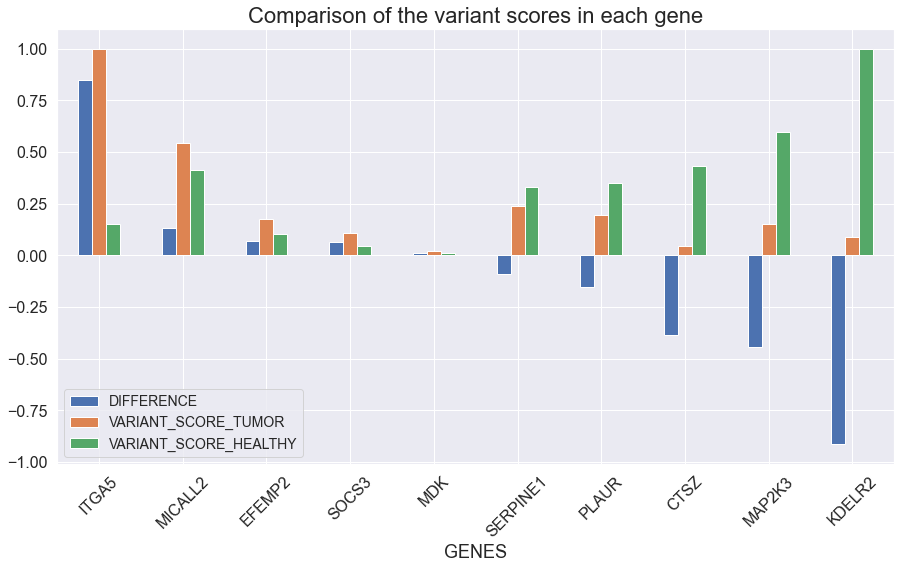

In [13]:
df4 = pd.merge(df3, df2, how='left', on=['GENE'], suffixes=('_HEALTHY', '_TUMOR'))
df4['DISTANCE'] = df4.apply(lambda r: r['VARIANT_SCORE_TUMOR'] - r['VARIANT_SCORE_HEALTHY'], axis=1)
df4.sort_values('DISTANCE', ascending=False, inplace=True)
# plot
df4_2 = df4.drop(['SCORE(NOT_NORM)_HEALTHY', 'SCORE(NOT_NORM)_TUMOR'], axis=1)
df4_2 = pd.pivot_table(df4_2, index='GENE').sort_values('DISTANCE', ascending=False)
df4_2 = df4_2[['DISTANCE',
               'VARIANT_SCORE_TUMOR', 'VARIANT_SCORE_HEALTHY']]
df4_2.plot(
    kind='bar',
    figsize=(15, 8),
    legend=True
)
plt.title('Comparison of the variant scores in each gene', fontsize=22)
plt.xlabel("GENES", fontsize=18)
plt.xticks(rotation=45, fontsize=16)
plt.yticks(fontsize=16)
plt.legend(['DIFFERENCE',
            'VARIANT_SCORE_TUMOR', 'VARIANT_SCORE_HEALTHY'], loc=3, fontsize=14)
plt.show()
# table
df4

### The comparison of the germline variation and somatic mutation profiles shows that ITGA5 is likely to be functionally related to the growth of skin cutaneous mealnoma. 
By the way, the articles cited below reinforce this conclusion and the effectiveness of the method used to identify genes related to a particular tumor form.

References:
- Przytycki, P. F., & Singh, M. (2017). Differential analysis between somatic mutation and germline variation profiles reveals cancer-related genes. Genome medicine, 9(1), 79. https://doi.org/10.1186/s13073-017-0465-6
- Nurzat, Y., Su, W., Min, P., Li, K., Xu, H., & Zhang, Y. (2021). Identification of therapeutic targets and prognostic biomarkers among integrin subunits in the skin cutaneous melanoma microenvironment. Frontiers in Oncology, 11, 751875.